In [583]:
%%HTML
<H2> Welcome, team Cobras </h2>
</br>

In [848]:
import time
import os
import csv
import json
import re
import operator
from collections import OrderedDict
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from collections import Counter
import math
import requests

In [680]:
print("Current datime:", time.strftime("%b %d %Y %H:%M:%S", time.gmtime(time.time())))
print("Contents:", os.listdir(os.getcwd()))

Current datime: Dec 11 2016 03:15:59
Contents: ['unique_addresses_2013-2016.csv', '.ipynb_checkpoints', 'data', 'team_cobras_1.ipynb']


In [681]:
%%html
<h1>Analysis of # of violations for a given year/boro</h1>
</br></br>

In [682]:
%%html
<h3> Define Year and Boro to analyze</h3>

In [780]:
YEAR = 2016
BORO = "manhattan"

In [781]:
%%html
<h3>Read csv data file and load into a python dictionary</h3>

In [782]:
filename = "data/dob_violations_" + str(YEAR) + ".csv"
with open(filename) as fh:
    fieldnames = fh.readline().strip().split(",")
    reader = csv.DictReader(fh, fieldnames)
    dlines = []
    for row in reader:
        dlines.append(row)

In [783]:
%%html
<h3>Group violations by borough</h3>

In [784]:
by_boro = {x:[] for x in [1, 2, 3, 4, 5]}
er = 0
for line in dlines:
    try:
        by_boro[int(line['BORO'])].append(line)
    except Exception as e:
        er +=1
print("Errors:", er)

Errors: 0


In [785]:
%%html
<h4>View first entry (violation) in Manhattan</h4>

In [786]:
by_boro[1][0]

{'BIN': '1011183',
 'BLOCK': '00620',
 'BORO': '1',
 'DESCRIPTION': '',
 'DEVICE_NUMBER': '',
 'DISPOSITION_COMMENTS': '',
 'DISPOSITION_DATE': '',
 'ECB_NUMBER': '',
 'HOUSE_NUMBER': '243',
 'ISN_DOB_BIS_VIOL': '2046888',
 'ISSUE_DATE': '20160513',
 'LOT': '00001',
 'NUMBER': 'V051316LANDMK16-1196',
 'STREET': 'WEST   10 STREET',
 'VIOLATION_CATEGORY': 'V-DOB VIOLATION - ACTIVE',
 'VIOLATION_NUMBER': '16-1196',
 'VIOLATION_TYPE': 'LANDMK-LANDMARK',
 'VIOLATION_TYPE_CODE': 'LANDMK'}

In [787]:
%%html
<h3>Normalize address nomenclature (Avenue/AV/AVE, EAST/E, WEST/W, etc) </h3>

In [788]:
# Convert "EAST" and "WEST" in addresses to "E" and "W"
E = re.compile('EAST*', re.IGNORECASE)
W = re.compile('WEST*', re.IGNORECASE)
A = re.compile('AVENUE', re.IGNORECASE)
S = re.compile('STREET', re.IGNORECASE)
Av = re.compile('AVE', re.IGNORECASE)
Aven = re.compile('AVEN$', re.IGNORECASE)
ordinal = re.compile('[0-9]TH|[0-9]RD|[0-9]ST', re.IGNORECASE)

for x in by_boro:
    for y in by_boro[x]:
        y["STREET"] = re.sub("EAST", "E", y.get("STREET").upper() )
        y["STREET"] = re.sub("WEST", "W", y.get("STREET").upper() )
        y["STREET"] = re.sub("\.", "", y.get("STREET").upper() )
        y["STREET"] = re.sub("STREET|STREE$", "ST", y.get("STREET").upper() )
        y["STREET"] = re.sub("STREE $", "ST ", y.get("STREET").upper() )
        y["STREET"] = re.sub("AVENUE", "AV", y.get("STREET").upper() )
        y["STREET"] = re.sub("AVEN$|AVE$", "AV", y.get("STREET").upper() )
        y["STREET"] = re.sub("AVEN ", "AV ", y.get("STREET").upper() )
        if ordinal.search(y.get("STREET")):
            r = ordinal.search(y.get("STREET")).span()
            start, end = r[0], r[1]
            y["STREET"] = " ".join((y["STREET"][:start] + " AV " + y["STREET"][end:]).split())
        # remove multiple spaces
        y["STREET"] = " ".join(y["STREET"].split())
        y["STREET"] = re.sub("ROAD", "RD", y.get("STREET").upper() )
        y["STREET"] = re.sub("PLACE", "PL", y.get("STREET").upper() )
        y["STREET"] = re.sub("BOULEVARD", "BLVD", y.get("STREET").upper() )

In [789]:
#by_boro[1]

In [790]:
%%html
<h3>Create dictionaries for unique street address, and dictionary of counts of violation / building by grouped by borough</h3>

In [791]:
street_addresses={x:{} for x in [1, 2, 3, 4, 5]}  # user later to request geolocation, only once per building
building_counts = {x:{} for x in [1, 2, 3, 4, 5]}

for boro in by_boro:
    for violation in by_boro[boro]:
        building = (violation.get("HOUSE_NUMBER").strip() + " " + violation.get("STREET"))
        if building not in building_counts[boro]:
            building_counts[boro][building] = 1
        else: 
            building_counts[boro][building] += 1
        if violation.get("STREET") not in street_addresses[boro]:
            street_addresses[boro][violation.get("STREET")] = set()
        street_addresses[boro][violation.get("STREET")].add(violation.get("HOUSE_NUMBER"))
        
with open("data/unique_buildings_" + str(YEAR) + ".csv" , "w") as fh:
    fh.write("boro,door_number,street_address\n")
    for boro in [1, 2, 3, 4, 5]:
        for street in street_addresses[boro]:
            for door in street_addresses[boro][street]:
                #print(street, door)
                fh.write(str(boro))
                fh.write(",")
                fh.write(door.strip())
                fh.write(",")
                fh.write(street.strip())
                fh.write("\n")
            

In [792]:
%%html
<h3>Sort buildings (descending) by number of violations</h3>

In [793]:
for boro in [1, 2, 3, 4, 5]:
    building_counts[boro] = OrderedDict(sorted(building_counts[boro].items(), key=operator.itemgetter(1), reverse=True))

In [794]:
%%html
<h3> Number of Unique STREETS in each borough</h3>

In [795]:
print("Manhattan:", len(street_addresses[1]))
print("Queens:", len(street_addresses[2]))
print("Brooklyn:", len(street_addresses[3]))
print("Bronx:", len(street_addresses[4]))
print("Staten Island:", len(street_addresses[5]))


Manhattan: 803
Queens: 856
Brooklyn: 1220
Bronx: 1169
Staten Island: 406


In [796]:
%%html
<h3>Total number of violations in each borough</h3>

In [797]:
print("Manhattan:", len(by_boro[1]))
print("Queens:", len(by_boro[2]))
print("Brooklyn:", len(by_boro[3]))
print("Bronx:", len(by_boro[4]))
print("Staten Island:", len(by_boro[5]))

Manhattan: 33304
Queens: 9617
Brooklyn: 18837
Bronx: 12091
Staten Island: 1694


In [798]:
%%html
<h3> Write building counts

In [799]:
# write data to csv file
boro = {"manhattan":1, "queens":4, "brooklyn":3, "bronx":2, "statenisland":5}

for b in boro:
    filename = "data/counts_" + b + ".csv"
    with open(filename, "w") as fh:
        fh.write("building,counts\n")
        for x in building_counts[boro[b]]:
            fh.write(x)
            fh.write(",")
            fh.write(str(building_counts[boro[b]][x]))
            fh.write("\n")


In [800]:
%%html
<h1> Analyze violation distribution for Year and Boro</h1>

In [801]:
print("Boro:", BORO)
print("Year:", YEAR)
filename = 'data/counts_' + BORO + '.csv'


Boro: manhattan
Year: 2016


In [802]:
%%html
<h3>Load data into a Pandas dataframe</h3>

In [803]:
df = pd.read_csv(filename)

In [804]:
%%html
<h3>Buildings with highest number of violations:</h3>

In [805]:
print(df.head())

      building  counts
0     441 7 AV     107
1  55 WATER ST      99
2    1 WALL ST      73
3   10 WALL ST      71
4  111 E 33 ST      64


In [806]:
%%html
<h3>Graphical analysis of the distribution of violations per building</h3>

      building  counts
0     441 7 AV     107
1  55 WATER ST      99
2    1 WALL ST      73
3   10 WALL ST      71
4  111 E 33 ST      64
 
Mean number of violation per building: counts    2.833901
dtype: float64
Median of number of violations per building: counts    2.0
dtype: float64
 
Statistics, including percentiles:
             counts
count  11752.000000
mean       2.833901
std        4.077412
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
85%        4.000000
90%        6.000000
95%        8.000000
97%       11.000000
99%       20.000000
max      107.000000


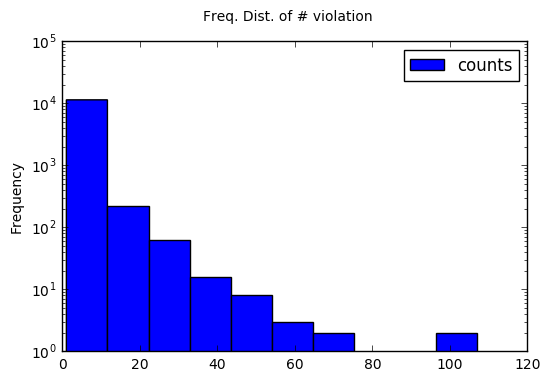

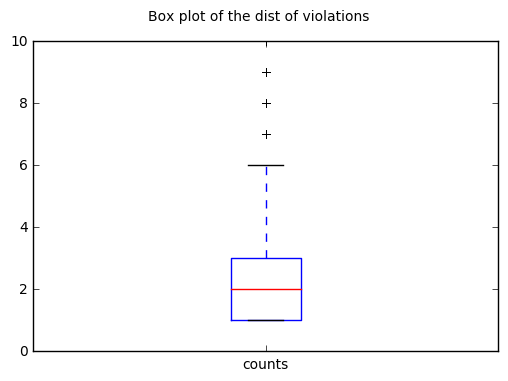

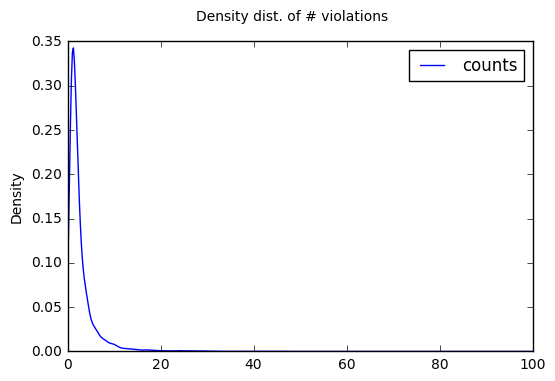

In [807]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from collections import Counter

print(df.head())
print(" ")
print("Mean number of violation per building:", df.mean())
print("Median of number of violations per building:", df.median())
print(" ")
print("Statistics, including percentiles:")
print(df.describe(percentiles=[.25,.5,.75, .85, .90, .95, .97, .99]))

fig = plt.figure(1, figsize=(5.5,5.5))
ax = df.plot(kind="hist", logy=True, subplots=True, legend="AAA", use_index=False, title="Freq. Dist. of # violation")
plt.legend()
df.plot(kind="box", ylim=(0,10), subplots=True, title="Box plot of the dist of violations")
df.plot(kind="kde", xlim=(0,100), subplots=True, title="Density dist. of # violations")
plt.show()


In [808]:
%%html
<H1>Conclusion</h1>
<h4>Half the buldings have only a 1 or 2 violations. Very few buildings have 10s of violations. Macy's has over 100 complaints, mostly about client accidents in the property</h4>
</br></br>
<h1>******************************************</h1>

In [809]:
%%html
<h3>You can perform shell operations right from the notebook</h3>

In [810]:
%%bash
sudo -H pip3 install seaborn
pip3 install --upgrade pip

Requirement already up-to-date: pip in /home/ubuntu/.local/lib/python3.5/site-packages


You are using pip version 8.1.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [811]:
"""
see https://blog.dominodatalab.com/lesser-known-ways-of-using-notebooks/ for some less known neat tricks
"""

'\nsee https://blog.dominodatalab.com/lesser-known-ways-of-using-notebooks/ for some less known neat tricks\n'

In [812]:
%%html
<h3>Create file of all unique addresses found from 2013-2016</h3>
<strong> To be used to get locations from google geolocation, minimizing calls</h3>

In [820]:
addresses = {5:{}, 1:{}, 2:{}, 3:{}, 4:{}}

def run(reader_):
    for row in reader_: 
        if row["street_address"] not in addresses[int(row["boro"])]:
            addresses[int(row["boro"])][row["street_address"]] = set()
        addresses[int(row["boro"])][row["street_address"]].add(row["door_number"])
                
with open("data/unique_buildings_2013.csv") as csvfile:
    reader1 = csv.DictReader(csvfile, delimiter=',', quotechar='|')
    run(reader1)
with open("data/unique_buildings_2014.csv") as csvfile:
    reader2 = csv.DictReader(csvfile, delimiter=',', quotechar='|')
    run(reader2)
with open("data/unique_buildings_2015.csv") as csvfile:
    reader3 = csv.DictReader(csvfile, delimiter=',', quotechar='|')
    run(reader3)
with open("data/unique_buildings_2016.csv") as csvfile:
    reader4 = csv.DictReader(csvfile, delimiter=',', quotechar='|')
    run(reader4)

with open('data/unique_addresses_2013-2016.csv', "w") as fh:
    fh.write("boro,door_number,street_address\n")
    for boro in [1, 2, 3, 4, 5]:
        for building in addresses[boro]:
            for door in addresses[boro][building]:
                fh.write(str(boro))
                fh.write(",")
                fh.write(door)
                fh.write(",")
                fh.write(building)
                fh.write("\n")

In [814]:
%%html
<h4> total number of unique buildings per boro</h4>

In [860]:
%%bash
grep "^1" data/unique_buildings_2014.csv | wc -l
grep "^2" data/unique_buildings_2014.csv | wc -l
grep "^3" data/unique_buildings_2014.csv | wc -l
grep "^4" data/unique_buildings_2014.csv | wc -l
grep "^5" data/unique_buildings_2014.csv | wc -l

18313
7113
15561
10762
1448
